# Hello, CIFAR10!

I started with MNIST, where classical techniques can do surprisingly well (>98% accuracy) and NN approaches are hard to compare due to them all doing so well (>99% easy with current techniques). Let's make this a _little_ harder by moving to CIFAR10, with 32x32 RGB images (vs. 28x28 grayscale). Here, about 96.5% accuracy is state-of-the-art and >90% is great: https://arxiv.org/ftp/arxiv/papers/1901/1901.06032.pdf      

We're actually making it _a lot_ harder than MNIST because these images are pretty hard to make sense of, even as a human. Also, I'm running this on a CPU because I'm on Bash-on-Ubuntu-on-Windows and I don't want to fight with Tensorflow to get it to recognize my GPU.    
 
__writeup todo__

## classical

pca / ica / umap
+ svm / gbt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


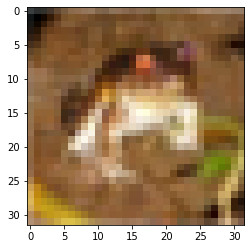

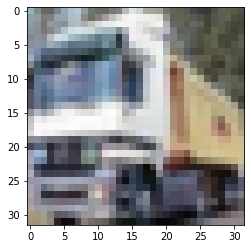

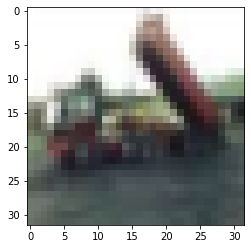

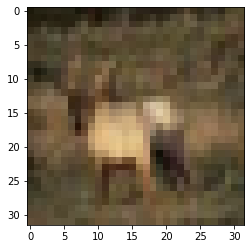

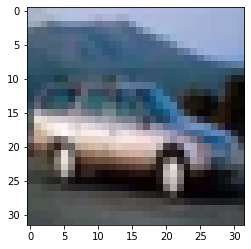

In [2]:
# preview a few
# very low-res images, hard for humans to ID 

for i in range(5):
    plt.imshow(x_train[i])
    plt.show()

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, NMF, FastICA 
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from umap import UMAP
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

N_COMPONENTS = 50

std_scaler = StandardScaler(with_mean=True, with_std=True)

pca = PCA(n_components=N_COMPONENTS, random_state=42)
nmf = NMF(n_components=N_COMPONENTS, random_state=42, max_iter=500, init='nndsvda')

svc = SVC(
    C=1.0,
    kernel='rbf',
    probability=False,
)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=.5,
    n_jobs=-1,
    random_state=42,
)
lgbc = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=.05,
    subsample=.9,
    random_state=42,
)
sklgbc = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=1_000,
    max_leaf_nodes=31,
    max_depth=6,
    min_samples_leaf=10,
    l2_regularization=1.0,
    max_bins=255,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0,
    random_state=42,
)

pca_pipe = make_pipeline(std_scaler, pca, sklgbc)
nmf_pipe = make_pipeline(nmf, sklgbc)
lgb_pipe = make_pipeline(nmf, lgbc)
rf_pipe = make_pipeline(nmf, rf)
svm_pipe = make_pipeline(nmf, svc)
# note: have to reduce before umap or we'll get errors. 
# defaulting to nmf b/c all pos. image data
# edit: struggles past n=1k or so, even with preprocessing. omit.  
#umap_pipe = make_pipeline(smol_nmf, std_scaler, umap, gb)

# Get dims + reshape from 2d per sample to standard instances x features.
n, x_dim, y_dim, z_dim = x_train.shape
x_train_flat = x_train.reshape((n, x_dim * y_dim * z_dim))

n, x_dim, y_dim, z_dim = x_test.shape
x_test_flat = x_test.reshape((n, x_dim * y_dim * z_dim))

/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [18]:

for model in [pca_pipe, nmf_pipe, lgb_pipe, rf_pipe, svm_pipe]:
    model.fit(x_train_flat, y_train)

    #pred_probs = model.predict_proba(x_test_flat)
    pred_classes = model.predict(x_test_flat)

    # AUC as we'd often use in traditional balanced-ish tabular problems.
    #auc = roc_auc_score(
    #    y_test, pred_probs, multi_class="ovr", average="weighted",
    #)
    
    # Also accuracy, since MNIST is often judged this way, and it's an imbalanced, multiclass problem.
    acc = accuracy_score(
        y_test, pred_classes
    )

    print('\n\n')
    print(acc, '\n', model)

/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)





0.5045 
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=1.0,
                                                learning_rate=0.05, max_depth=6,
                                                max_iter=1000,
                                                min_samples_leaf=10,
                                                random_state=42))])


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)





0.5353 
 Pipeline(steps=[('nmf',
                 NMF(init='nndsvda', max_iter=500, n_components=50,
                     random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=1.0,
                                                learning_rate=0.05, max_depth=6,
                                                max_iter=1000,
                                                min_samples_leaf=10,
                                                random_state=42))])


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)





0.5226 
 Pipeline(steps=[('nmf',
                 NMF(init='nndsvda', max_iter=500, n_components=50,
                     random_state=42)),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.05, n_estimators=500,
                                random_state=42, subsample=0.9))])


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)





0.3881 
 Pipeline(steps=[('nmf',
                 NMF(init='nndsvda', max_iter=500, n_components=50,
                     random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, max_features=0.5,
                                        min_samples_leaf=5,
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=42))])


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)





0.4205 
 Pipeline(steps=[('nmf',
                 NMF(init='nndsvda', max_iter=500, n_components=50,
                     random_state=42)),
                ('svc', SVC())])


yay? it's harder, as I had hoped.

## Basic CNN

In [13]:
import tensorflow as tf


BATCH_SIZE = 128  # running on CPU, which is obviously slow  

# convert class vectors to binary class matrices
y_train_ohe = keras.utils.to_categorical(y_train, num_classes)
y_test_ohe = keras.utils.to_categorical(y_test, num_classes)

tf.config.list_physical_devices('GPU')

[]

In [20]:
# copypasta, just increase epochs

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_ohe, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test_ohe, verbose=0)
print("Base model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2304)             

In [25]:
# lightly tuned

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        layers.RandomFlip("horizontal"), 
        layers.RandomRotation(0.05),
        layers.RandomContrast(0.05),
        layers.RandomZoom((-0.05, 0.05), (-0.05, 0.05)),
        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_5 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 random_contrast (RandomCont  (None, 32, 32, 3)        0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 32)      

In [26]:
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# note: would be better to use augmented data
model.fit(x_train, y_train_ohe, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test_ohe, verbose=0)
print("Mildly tuned model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/20
176/176 [==============================] - 39s 219ms/step - loss: 1.8250 - accuracy: 0.3527 - val_loss: 2.9062 - val_accuracy: 0.1512
Epoch 2/20
176/176 [==============================] - 38s 217ms/step - loss: 1.4126 - accuracy: 0.4972 - val_loss: 2.2691 - val_accuracy: 0.2378
Epoch 3/20
176/176 [==============================] - 37s 209ms/step - loss: 1.2223 - accuracy: 0.5728 - val_loss: 1.0193 - val_accuracy: 0.6518
Epoch 4/20
176/176 [==============================] - 37s 210ms/step - loss: 1.0901 - accuracy: 0.6250 - val_loss: 0.9840 - val_accuracy: 0.6688
Epoch 5/20
176/176 [==============================] - 37s 210ms/step - loss: 0.9909 - accuracy: 0.6647 - val_loss: 0.8851 - val_accuracy: 0.6972
Epoch 6/20
176/176 [==============================] - 37s 213ms/step - loss: 0.9238 - accuracy: 0.6859 - val_loss: 0.9350 - val_accuracy: 0.6932
Epoch 7/20
176/176 [==============================] - 37s 208ms/step - loss: 0.8705 - accuracy: 0.7061 - val_loss: 0.8815 - val_ac

In [ ]:
# basic: 69.6
# add 2x 128 hidden w/ .5 dropout: 69.2
# add 2nd conv before each maxpool: 72.2  
# add mild 0.2 dropout after each conv+maxpool: 73.0
# add batch norm after each conv+maxpool block: 75.0
# add batch norm after every single layer: 72.3
# batch norm after each conv+maxpool and dense: 72.0
# batch norm after every non-dense layer: 76.0
# make 2nd conv 64,64 instead of 32,64 (whoops): 77.3
# add third cnn,cnn,maxpool block, with 128 size: 81.8! (CPU reallly struggling at this point, about 15min.)  
# add simple random rotation and horizontal flip: 80.6
# tone down transf.: 83.9
# add random zoom + contrast: 81.7
# make zoom and contrast milder (.1 -> .05): 

# pretty happy with this performance considering how simple our architecture is, 
#   and that we're using 2014-era techniques :laugh:

In [14]:
x_train.shape

(50000, 32, 32, 3, 1)

## Try using a pretrained CNN (Xception)  

In [34]:
MIN_SZ_FOR_XCEPTION = (71, 71, 3)

base_model = keras.applications.Xception(
    weights='imagenet', 
    include_top=False,        # omit imagenet classification layer
    input_shape=MIN_SZ_FOR_XCEPTION,  # we'll hack 32x32 up to 71x71 :)
)

# Freeze the base_model
base_model.trainable = False

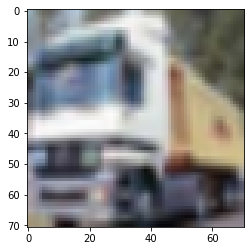

In [35]:
import tensorflow as tf

x_train_71px = tf.image.resize(x_train, (71, 71))
x_test_71px = tf.image.resize(x_test, (71, 71))


plt.imshow(tf.image.resize(x_train[1], (71, 71)))

In [37]:
np.min(x_train)
np.max(x_train)

1.0

In [39]:
# copy-paste + tweak from keras tutorial
# https://keras.io/guides/transfer_learning/

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# our inputs are 0-1, so -.5 to center at 0 then * by 2
scale_layer = keras.layers.Rescaling(scale=2, offset=-0.5)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),
        layers.RandomFlip(mode="horizontal")
    ]
)
inputs = keras.Input(shape=MIN_SZ_FOR_XCEPTION)
x = data_augmentation(inputs)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 sequential_9 (Sequential)   (None, 71, 71, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 71, 71, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_23 (Dropout)        (None, 2048)              0         
                                                           

In [40]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

epochs = 10  # FIXME TO 20  
model.fit(x_train_71px, y_train_ohe, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test_71px, y_test_ohe, verbose=0)
print("Frozen XCeption + dense layer:")
print("Test loss:", score[0])
print("Test accuracy:", score[1])


#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# note: would be better to use augmented data
#model.fit(x_train, y_train_ohe, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1)



Epoch 1/10
1407/1407 [==============================] - 96s 67ms/step - loss: 1.2707 - accuracy: 0.5817 - val_loss: 0.9058 - val_accuracy: 0.7016
Epoch 2/10
1407/1407 [==============================] - 92s 65ms/step - loss: 1.1452 - accuracy: 0.6252 - val_loss: 0.8898 - val_accuracy: 0.7076
Epoch 3/10
1407/1407 [==============================] - 93s 66ms/step - loss: 1.1211 - accuracy: 0.6328 - val_loss: 0.8734 - val_accuracy: 0.7154
Epoch 4/10
1407/1407 [==============================] - 93s 66ms/step - loss: 1.1062 - accuracy: 0.6334 - val_loss: 0.8733 - val_accuracy: 0.7150
Epoch 5/10
1407/1407 [==============================] - 94s 67ms/step - loss: 1.1027 - accuracy: 0.6370 - val_loss: 0.8573 - val_accuracy: 0.7214
Epoch 6/10
1407/1407 [==============================] - 94s 67ms/step - loss: 1.1079 - accuracy: 0.6372 - val_loss: 0.8669 - val_accuracy: 0.7222
Epoch 7/10
1407/1407 [==============================] - 91s 65ms/step - loss: 1.1027 - accuracy: 0.6374 - val_loss: 0.8725 -

obviously not remotely perfectly fine-tuned, but accuracy seems to have plateaued after just 3-5 epochs at around 70%.  

In [41]:
# try fine tuning, again copy-pasta

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 5
model.fit(x_train_71px, y_train_ohe, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test_71px, y_test_ohe, verbose=0)
print("Add fine-tuning")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 sequential_9 (Sequential)   (None, 71, 71, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 71, 71, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_23 (Dropout)        (None, 2048)              0         
                                                           

/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1407/1407 [==============================] - 450s 319ms/step - loss: 0.6595 - categorical_accuracy: 0.7740 - val_loss: 0.3811 - val_categorical_accuracy: 0.8678
Epoch 2/5
1407/1407 [==============================] - 453s 322ms/step - loss: 0.4482 - categorical_accuracy: 0.8448 - val_loss: 0.3345 - val_categorical_accuracy: 0.8908
Epoch 3/5
1407/1407 [==============================] - 447s 318ms/step - loss: 0.3700 - categorical_accuracy: 0.8733 - val_loss: 0.2863 - val_categorical_accuracy: 0.9018
Epoch 4/5
1407/1407 [==============================] - 445s 316ms/step - loss: 0.3128 - categorical_accuracy: 0.8914 - val_loss: 0.2690 - val_categorical_accuracy: 0.9068
Epoch 5/5
1407/1407 [==============================] - 443s 315ms/step - loss: 0.2727 - categorical_accuracy: 0.9039 - val_loss: 0.2573 - val_categorical_accuracy: 0.9148
Add fine-tuning
Test loss: 0.2710954546928406
Test accuracy: 0.909500002861023


and we actually improved performance dramatically with some fine-tuning. (we probably could've run longer.)    

so in accuracy terms:  
- .54 classical/gbt  
- .69 really basic NN  
- .82 slightly less basic NN  
- .70 pretrained XCeption w/ one dense layer on top  
- .91 also fine-tune whole network  